# Exploration 16. pix2pix
---
# (프로젝트) Segmentation map으로 도로 이미지 만들기

## [루브릭]
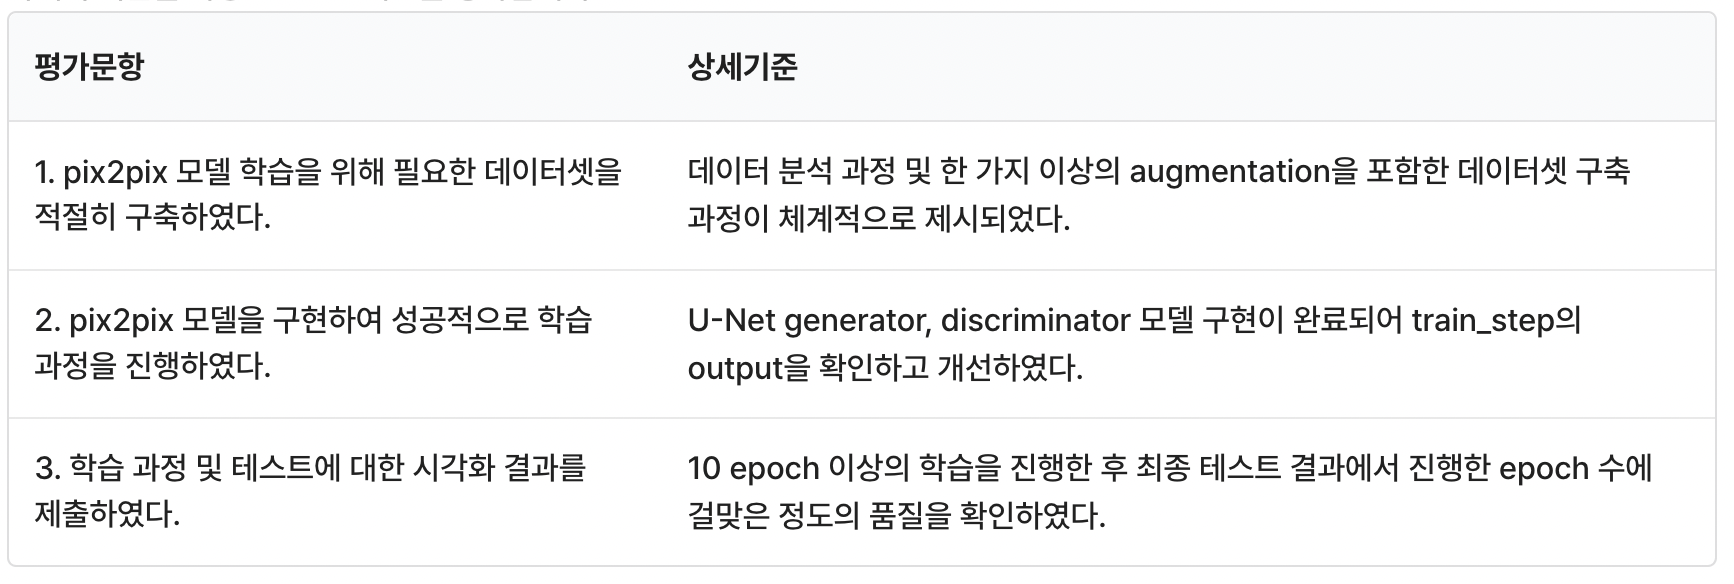

데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.  
(어떠한 방법을 사용했는지 적어주세요.)  
이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.  
모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.  
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  
모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요.   

## STEP 1 : 데이터 로딩하기

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline
from IPython.display import Image

In [2]:
data_train_path = './data/cityscapes/train/'
data_test_path = './data/cityscapes/val/'
print("number of train examples : ", len(os.listdir(data_train_path )))
print("number of test examples : ", len(os.listdir(data_test_path )))

number of train examples :  1000
number of test examples :  5


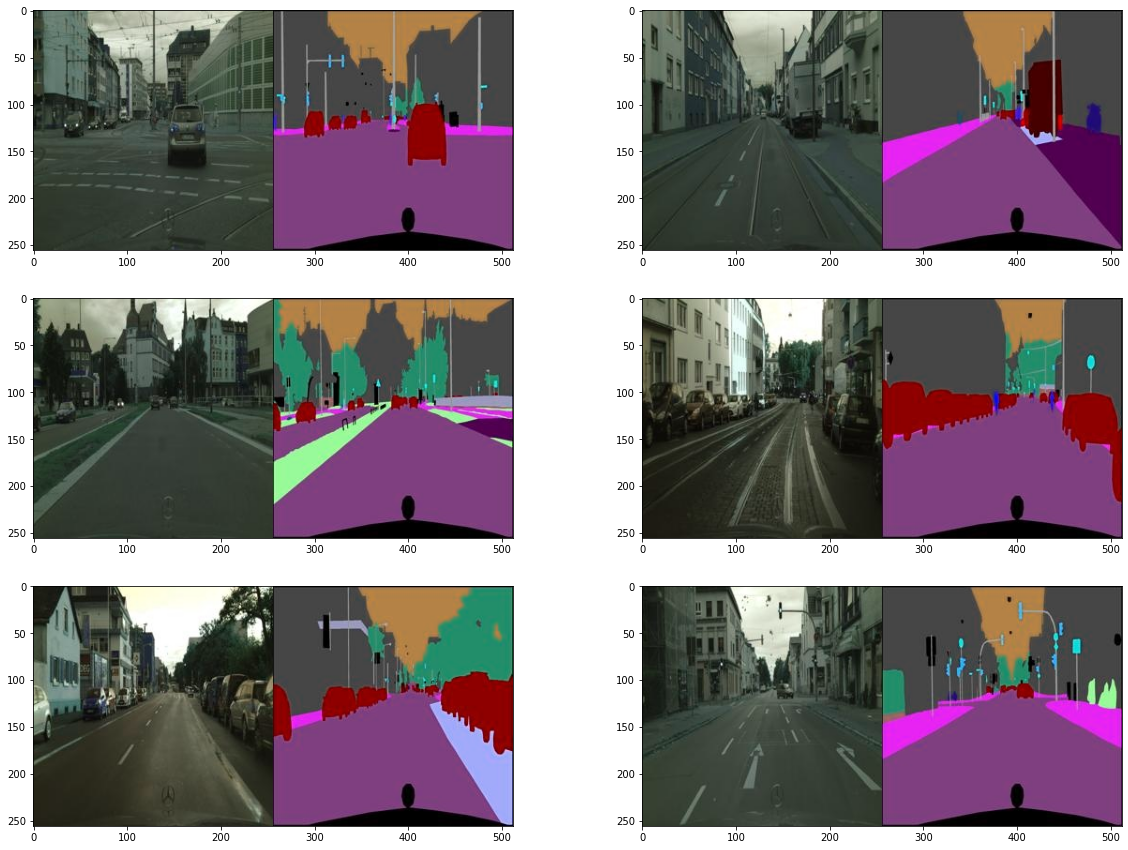

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_train_path + os.listdir(data_train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [4]:
f = data_train_path + os.listdir(data_train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5)-1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3, expand_animations = False)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :]
    real_image = tf.cast(real_image, tf.float32)
    seg_image = img[:, w:, :]
    seg_image = tf.cast(seg_image, tf.float32)
    
    return normalize(real_image), normalize(seg_image)

In [6]:
f = data_train_path + os.listdir(data_train_path)[10]
real_image, seg_image = load_img(f)

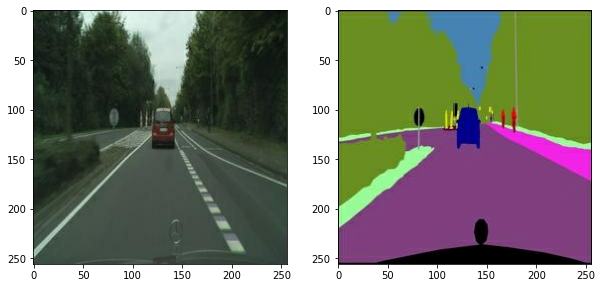

In [7]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(denormalize(real_image))

plt.subplot(1,2,2)
plt.imshow(denormalize(seg_image))

## STEP 2 : Data Augmentation

In [8]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

In [9]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def resize(real_image, seg_image, height, width):
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    seg_image = tf.image.resize(seg_image, [height, width], 
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return real_image, seg_image

In [11]:
def random_crop(real_image, seg_image):
    stacked_image = tf.stack([real_image, seg_image], axis=0)
    cropped_image = tf.image.random_crop(
    stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

In [12]:
@tf.function()
def random_jitter(real_image, seg_image):
    # resize to 286 x 286 x 3
    real_image, seg_image = resize(real_image, seg_image, 286, 286)
    
    # randomly cropping to 256 x 256 x 3
    real_image, seg_image = random_crop(real_image, seg_image)
    
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        real_image = tf.image.flip_left_right(real_image)
        seg_image = tf.image.flip_left_right(seg_image)
        
    return real_image, seg_image

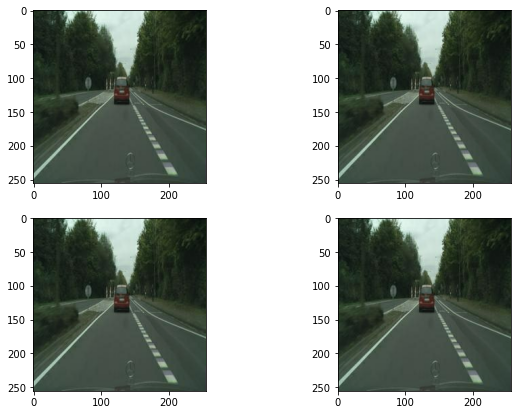

In [13]:
plt.figure(figsize=(10, 7))
for i in range(4):
    real, seg = random_jitter(real_image, seg_image)
    plt.subplot(2, 2, i+1)
    plt.imshow(denormalize(real_image))
plt.show()

In [14]:
def load_image_train(image_file):
    real_image, seg_image = load_img(image_file)
    real_image, seg_image = random_jitter(real_image, seg_image)
    
    return real_image, seg_image

In [15]:
train_dataset = tf.data.Dataset.list_files(data_train_path + '*.jpg')

In [16]:
train_dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None)>

In [17]:
def load_image_test(image_file):
    real_image, seg_image = load_img(image_file)
    real_image, seg_image = resize(real_image, seg_image, IMG_HEIGHT, IMG_WIDTH)
    
    return real_image, seg_image

In [18]:
train_dataset = tf.data.Dataset.list_files(data_train_path + '*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [20]:
test_dataset = tf.data.Dataset.list_files(data_test_path + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [21]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

## STEP 3 : 모델 구성 및 학습

In [22]:
from tensorflow.keras import layers, Input, Model

In [23]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True, initializer = tf.random_normal_initializer(0., 0.02)):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", kernel_initializer=initializer, use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True, initializer = tf.random_normal_initializer(0., 0.02)):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", kernel_initializer=initializer, use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [27]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [28]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [29]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [30]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [31]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False
                                               , activation='tanh')
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [32]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [33]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [34]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [35]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [36]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gen_loss(gen_image, real_image, fake_disc):
    l1_loss = mae(real_image, gen_image)
    gen_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gen_loss, l1_loss

In [37]:
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [38]:
def discriminator_accuracy(real_image, gen_image):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_image, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(gen_image, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [39]:
from tensorflow.keras import optimizers

gen_opt = optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
disc_opt = optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

In [40]:
generator = UNetGenerator()
discriminator = Discriminator()

In [41]:
@tf.function
def train_step(real_image, seg_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_image = generator(seg_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg_image, gen_image, training=True)
        real_disc = discriminator(seg_image, real_image, training=True)
        # Generator 손실 계산
        gen_loss, l1_loss = get_gen_loss(gen_image, real_image, fake_disc)
        gen_total_loss = gen_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
        # accuracry 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_disc, fake_disc)
                
    gen_gradient = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gen_loss, disc_loss , real_accuracy, fake_accuracy

In [43]:
gen_image_path = './data/cityscapes/generated'

In [44]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=True)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 2, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
        
    plt.savefig('{}/sample_epoch_{:04d}_iter_{:03d}.png'.format(gen_image_path, epoch, it))
    plt.show()  

In [45]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/train_history_{:04d}.png'.format(gen_image_path, epoch))
    plt.show()

In [46]:
checkpoint_dir = gen_image_path
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [47]:
import time
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, (real_image, seg_image) in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(real_image, seg_image)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seg_image)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
        
        if (epoch + 1) % save_every ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
                
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, it, seg_image)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


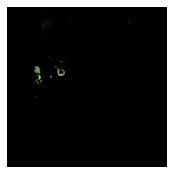

Time for training : 4847 sec


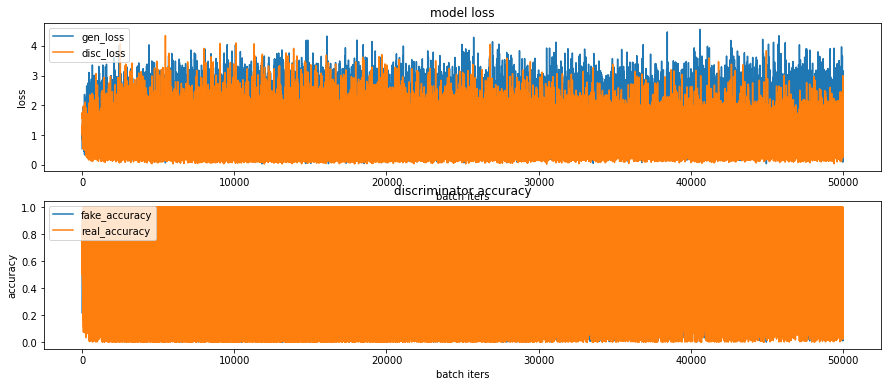

CPU times: user 35min 26s, sys: 5min 39s, total: 41min 5s
Wall time: 1h 20min 52s


In [48]:
%%time
EPOCHS = 50
save_every = 10
train(train_dataset, EPOCHS, save_every)

In [50]:
def generate_images(model, seg_image, real_image):
    prediction = model(seg_image, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [seg_image[0], prediction[0], real_image[0]]
    title = ['Input Image', 'Predicted Image', 'Ground Truth']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(denormalize(display_list[i]))
        # Getting the pixel values in the [0, 1] range to plot.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

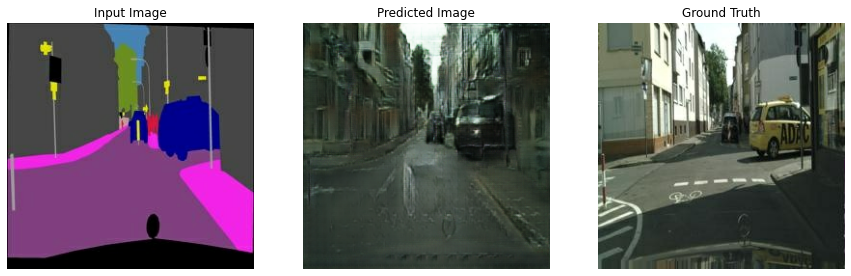

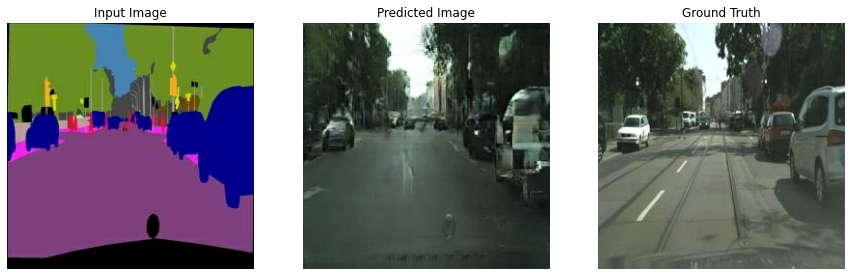

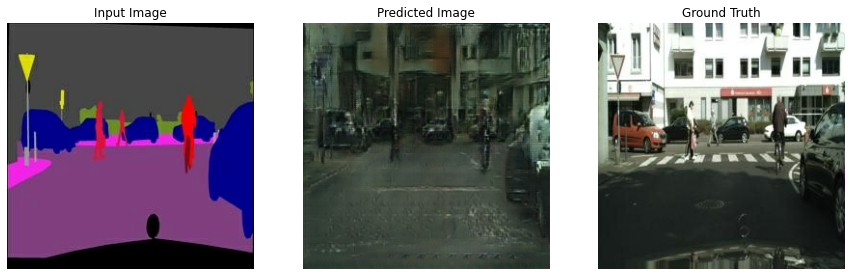

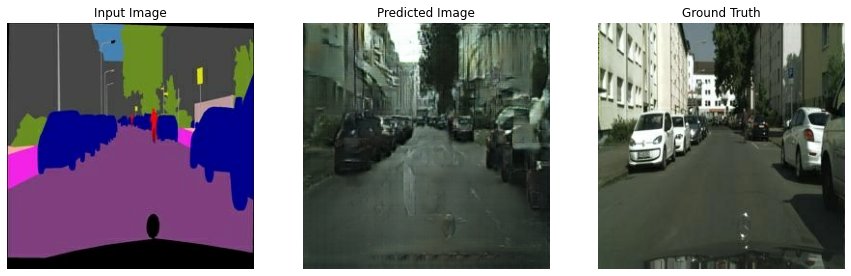

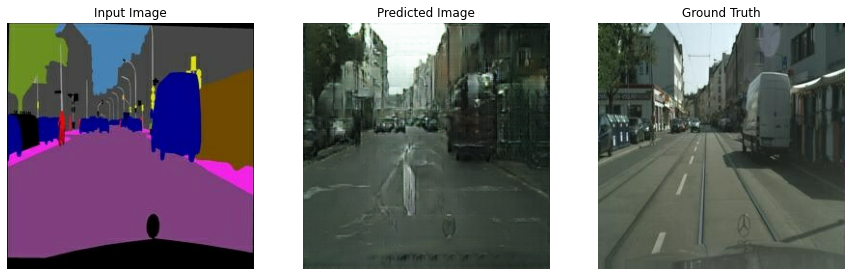

In [51]:
# Run the trained model on a few examples from the test set
for real_image, seg_image in test_dataset.take(5):
    generate_images(generator, seg_image, real_image)

## 기타 시도 : depthwise convolution을 활용한 연산 파라미터 줄이기 테스트

[참고]  
http://koreascience.or.kr/article/JAKO201919866854574.pdf

In [52]:
class DepthwiseSeparableConv2D(tf.keras.layers.Layer):
    def __init__(self, in_channel, out_channel, kernels_per_layer):
        super().__init__()
        self.depthwise = DepthwiseConv2D(in_channel, out_channel, kernels_per_layer)
        self.pointwise = Conv2D(in_channel * kernels_per_layer, out_channel, kernel_size=1)
    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [53]:
class EncodeBlock_depthwise(layers.Layer):
    def __init__(self, n_filters, use_bn=True, initializer = tf.random_normal_initializer(0., 0.02)):
        super(EncodeBlock_depthwise, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.SeparableConv2D(n_filters, 4, 2, "same", kernel_initializer=initializer, use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [54]:
class Encoder_depthwise(layers.Layer):
    def __init__(self):
        super(Encoder_depthwise, self).__init__()
        filters = [18,108,432,432,432,432,432,432]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock_depthwise(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock_depthwise(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [55]:
Encoder_depthwise().get_summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_depthwise (Enco (None, 128, 128, 18)      102       
_________________________________________________________________
encode_block_depthwise_1 (En (None, 64, 64, 108)       2664      
_________________________________________________________________
encode_block_depthwise_2 (En (None, 32, 32, 432)       50112     
_________________________________________________________________
encode_block_depthwise_3 (En (None, 16, 16, 432)       195264    
_________________________________________________________________
encode_block_depthwise_4 (En (None, 8, 8, 432)         195264    
_________________________________________________________________
encode_block_depthwise_5 (En (None, 4, 4, 432)         1952

In [56]:
class UNetGenerator_depthwise(Model):
    def __init__(self):
        super(UNetGenerator_depthwise, self).__init__()
        encode_filters = [18,108,432,432,432,432,432,432]
        decode_filters = [432,432,432,432,432,108,18]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock_depthwise(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock_depthwise(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False
                                               , activation='tanh')
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [57]:
generator = UNetGenerator_depthwise()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


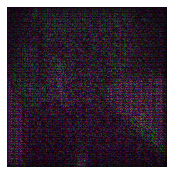

Time for training : 4788 sec


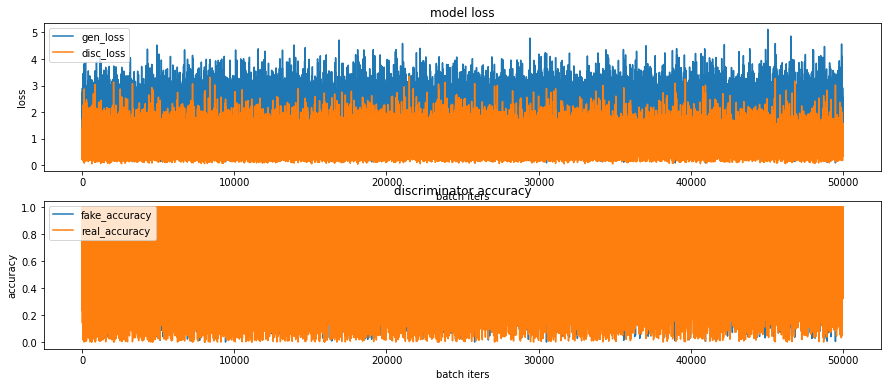

CPU times: user 34min 36s, sys: 5min 39s, total: 40min 16s
Wall time: 1h 19min 53s


In [58]:
%%time
EPOCHS = 50
save_every = 10
train(train_dataset, EPOCHS, save_every)

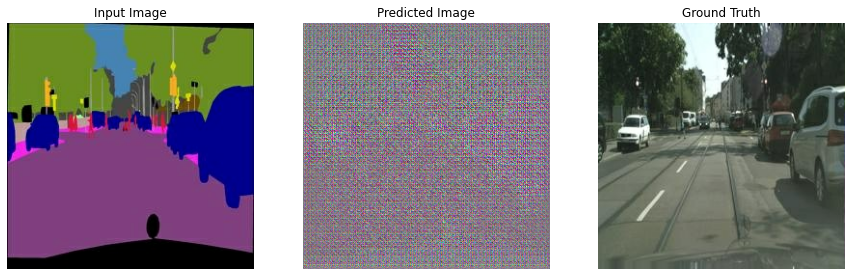

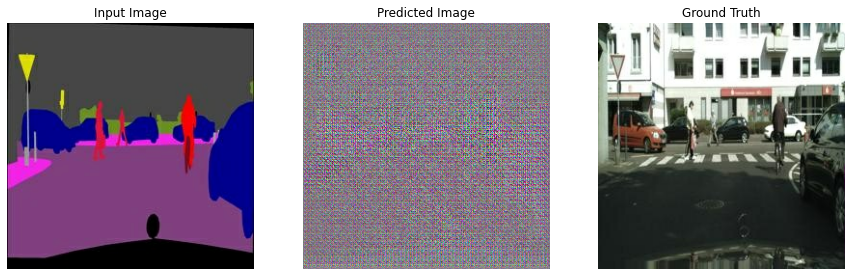

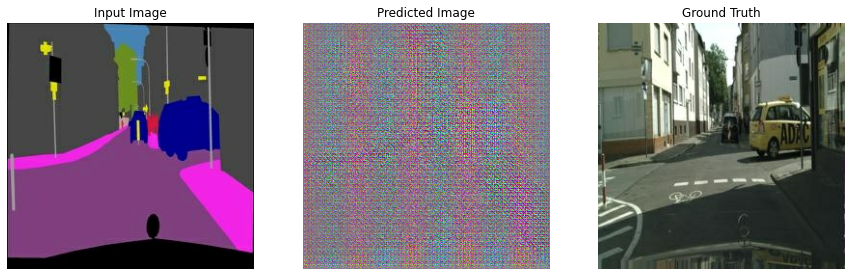

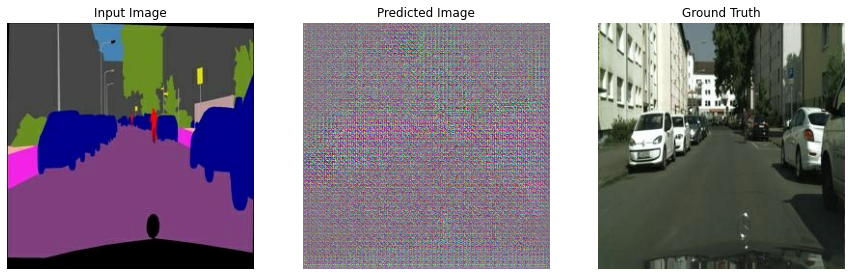

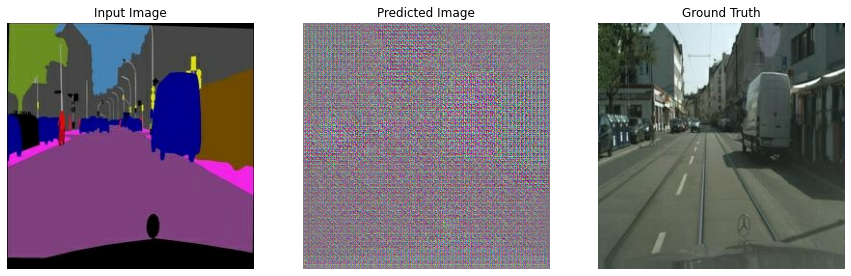

In [59]:
# Run the trained model on a few examples from the test set
for real_image, seg_image in test_dataset.take(5):
    generate_images(generator, seg_image, real_image)

## 회고  
- 이미지 생성 결과 원본 이미지와 유사하게 생성되는 것을 확인할 수 있었습니다. 하지만 아쉽게도 원본과는 퀄리티 측면에서 차이가 존재했으며, 일부 개선을 해보기 위해 시도를 해 보았으나 큰 개선 효과를 얻지는 못했습니다. 
- 개선 작업을 조사하던 중에 연산량을 줄이기 위해 depthwise convolution이라는 것을 사용한다는 것을 알게 되었고, 해당 시도를 해보았으나 설정상 문제가 있는지 생성 이미지는 제대로 생성되지는 못했습니다.   
- depthwise convolution에 대한 사용법에 대해 좀 더 연구가 필요할 것으로 판단되며, 추가로 추후 최종 결과물에 대한 퀄리티를 향상시키기 위해 super resolution이라는 기법도 추가로 스터디하여 적용해 보도록 하겠습니다. 